<a href="https://colab.research.google.com/github/MatousE/cnn-colon-classification/blob/main/colon_cancer_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install git+https://github.com/aleju/imgaug

import os
import torch
import torchvision
import numpy as np
import imgaug as ia
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import torchvision.transforms as T
from torchvision import datasets
from tqdm.notebook import tqdm
from sklearn.metrics import f1_score
from imgaug import augmenters as iaa

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
train_path = '/content/drive/MyDrive/cnn/data_colon_binary/train/'

test_path = '/content/drive/MyDrive/cnn/data_colon_binary/test/'

In [ ]:
train_transform = T.Compose([
    T.Grayscale(),
    T.GaussianBlur(kernel_size=(15, 15), sigma=5.0),
    T.RandomVerticalFlip(p=0.5),
    T.RandomHorizontalFlip(p=0.5),
    T.RandomApply(torch.nn.ModuleList([T.RandomAffine(degrees=(0, 90), scale=(0.75, 1))]), p=0.3),
    T.ToTensor()
])


test_transform = T.Compose([
    T.Grayscale(),
    T.ToTensor()
])


train_cancer_dataset = datasets.ImageFolder(train_path, transform=train_transform)
test_cancer_dataset = datasets.ImageFolder(test_path, transform=test_transform)

dataloader = {
    'train':torch.utils.data.DataLoader(train_cancer_dataset, batch_size=32, shuffle=True),
    'test':torch.utils.data.DataLoader(test_cancer_dataset, batch_size=32, shuffle=True)
}

classes = ('cancer', 'saint')

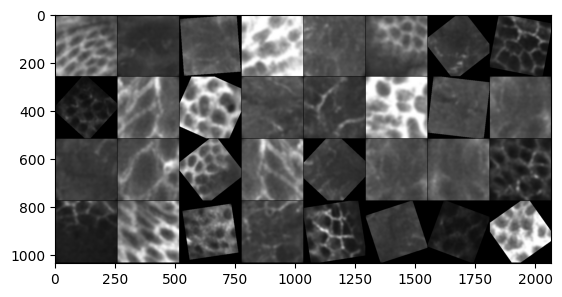

saint cancer cancer saint cancer saint cancer saint saint cancer saint cancer cancer saint cancer cancer cancer cancer saint cancer cancer cancer cancer saint saint saint saint cancer saint cancer saint saint


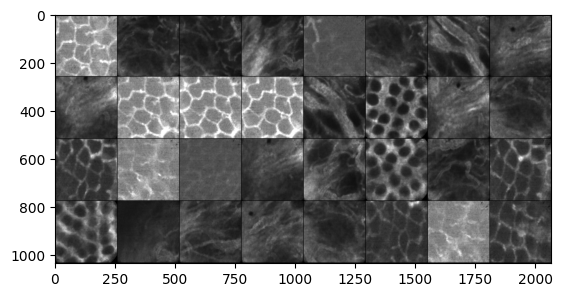

saint cancer cancer cancer saint cancer cancer cancer cancer saint saint saint cancer saint cancer cancer saint saint saint cancer cancer saint cancer saint saint cancer cancer cancer cancer saint saint saint


In [ ]:
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(dataloader['train'])
images, labels = next(dataiter)
imshow(torchvision.utils.make_grid(images))
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(32)))

dataiter = iter(dataloader['test'])
images, labels = next(dataiter)
imshow(torchvision.utils.make_grid(images))
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(32)))

In [ ]:
class ConvNeuralNet(nn.Module):
	#  Determine what layers and their order in CNN object 
    def __init__(self, num_classes):
        super(ConvNeuralNet, self).__init__()
        self.conv_layer1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1)
        self.conv_layer2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.max_pool1 = nn.MaxPool2d(kernel_size = 2, stride = 2)
        
        self.conv_layer3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv_layer4 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.max_pool2 = nn.MaxPool2d(kernel_size = 2, stride = 2)
        
        self.fc1 = nn.Linear(524288, 128)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(128, num_classes)
    
    # Progresses data across layers    
    def forward(self, x):
        out = self.conv_layer1(x)
        out = self.relu(out)
        out = self.conv_layer2(out)
        out = self.relu(out)
        out = self.max_pool1(out)
        
        out = self.conv_layer3(out)
        out = self.relu(out)
        out = self.conv_layer4(out)
        out = self.relu(out)
        out = self.max_pool2(out)
                
        out = out.reshape(out.size(0), -1)
        
        out = self.fc1(out)
        out = self.relu(out)
        out = self.fc2(out)
        return out

In [ ]:
device = ("cuda:0" if torch.cuda.is_available() else "cpu")
net = ConvNeuralNet(2).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

def train(model, dataloader):
  model.train()

  train_loss = 0
  for i, data in enumerate(dataloader, 0):
    inputs, labels = data[0].to(device), data[1].to(device)

    optimizer.zero_grad()

    out = model(inputs)
    loss = criterion(out, labels)
    loss.backward()
    optimizer.step()

    train_loss += loss.item()
  return train_loss / len(dataloader)

def test(model, dataloader):
  model.eval()

  test_loss = 0
  for i, data in enumerate(dataloader, 0):
    inputs, labels = data[0].to(device), data[1].to(device)

    out = model(inputs)
    loss = criterion(out, labels)

    test_loss += loss.item()
  return test_loss / len(dataloader)



epochs = 3
train_loss_lst = []
test_loss_lst = []
for epoch in range(epochs):
  train_loss = train(net, dataloader['train'])
  train_loss_lst.append(train_loss)

  test_loss = test(net, dataloader['test'])
  test_loss_lst.append(test_loss)

  print('Epoch [{}/{}], Train loss: {:.4f}, Test loss: {:.4f}'.format(epoch+1, epochs, train_loss, test_loss))


Epoch [1/3], Train loss: 0.6976, Test loss: 0.5643
Epoch [2/3], Train loss: 0.4734, Test loss: 0.6375
Epoch [3/3], Train loss: 0.2316, Test loss: 2.4800


In [ ]:
net.eval()

all_y = []
all_pred = []
for i, data in tqdm(enumerate(dataloader['test'], 0)):
  inputs, labels = data[0].to(device), data[1].to(device)

  all_y.extend(labels.cpu().numpy())
  out = net(inputs).argmax(dim=1)
  all_pred.extend(out.cpu().numpy())

f1_score(all_y, all_pred)

0it [00:00, ?it/s]

0.6511056511056511

In [ ]:
torch.cuda.empty_cache()